In [25]:
# Copyright (c) ContextualFairness contributors.
# Licensed under the MIT License.

# Contextual fairness for regression

We consider a hypothetical loan approval scenario where a bank uses an ML model to predict applicants’ income. This notebook contains the regression variant of this scenario, where an individual's income is predicted with a regression model. We analyze the fairness analysis of this model with a baseline using bounded group loss and with contextual fairness. 

This notebook matches the experiments for Regression in the paper *Assessing machine learning fairness with multiple contextual norms* (Section 4.2).

In [26]:
import sys

sys.path.append("../")

import numpy as np

from folktables import ACSDataSource, BasicProblem, adult_filter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt

from contextualfairness.scorer import contextual_fairness_score
from contextualfairness.norms import RegressionEqualityNorm, RankNorm

import polars as pl


from _helper import group_plot

font = {"size": 18}
matplotlib.rc("font", **font)

### Load data 

Using the 2016 California ACS Income data

In [27]:
data_source = ACSDataSource(
    survey_year="2016", horizon="1-Year", survey="person", root_dir="data/raw"
)
acs_data_ca = data_source.get_data(states=["CA"], download="True")

### Create regression data set

In [28]:
RegressionTask = BasicProblem(
    features=[
        "AGEP",
        "COW",
        "SCHL",
        "MAR",
        "OCCP",
        "POBP",
        "RELP",
        "WKHP",
        "SEX",
        "RAC1P",
    ],
    target="PINCP",
    target_transform=lambda x: x,
    group="SEX",
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

### Prepare data and create train/test data

Sex is used as the sensitive attribute.

In [29]:
X, y, _ = RegressionTask.df_to_pandas(acs_data_ca)
y = y["PINCP"]
sensitive_attribute = X["SEX"].copy()

X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X, y, sensitive_attribute, test_size=0.2, random_state=0
)

### Train model

In [30]:
clf = LinearRegression()
clf.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Predictions for test data

In [31]:
y_pred = clf.predict(X_test)

### Bounded group loss

The baseline is bounded group loss. This states that the loss for any group (e.g., males or females) should not be below a specified threshold. Consequently, for a sufficiently low threshold, there is no group for which the model performs much worse than the other groups.

For this case, we use the mean squared error as the loss, males and females as the groups, and the threshold is set to $1.2$ times the mean squared error for the entire model.

In [32]:
# define groups
males = sens_test == 1.0
females = sens_test == 2.0

# get loss for each group and total loss, with mean_squared_error as the loss
male_loss = mean_squared_error(y_test[males], y_pred[males])
female_loss = mean_squared_error(y_test[females], y_pred[females])
total_loss = mean_squared_error(y_test, y_pred)

### Plot results for bounded group loss

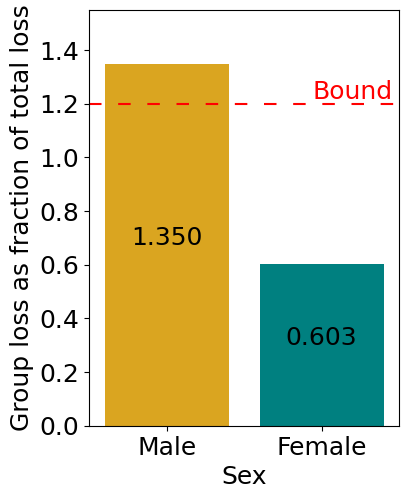

In [60]:
groups = [[male_loss / total_loss, female_loss / total_loss]]

group_plot(
    groups,
    xlabel="Sex",
    ylabel="Group loss as fraction of total loss",
    # title="\n",
    calc_ylim=True,
    bound=1.2,
    bound_interval=[-0.5, 1.5],
    show_difference=False,
    xticks=["Male", "Female"],
    bar_width=0.8,
    fig_width=4,
    fig_height=5.4,
)

### Contextual fairness with multiple norms

For contextual fairness, the following three norms are considered:

- Everybody should get the same prediction.
- People who work more hours should earn more.
- People with a lower education level should earn more.

The norms are weighed equally.

In [34]:
norms = [
    RegressionEqualityNorm(),
    RankNorm(norm_statement=pl.col("WKHP"), name="work_more_hours"),
    RankNorm(norm_statement=-pl.col("SCHL"), name="lower_education"),
]


# Add y_true to X_test, so we can calculate scores for the same groups as for equalized odds.
data = X_test.to_dict("list")

result = contextual_fairness_score(norms, data, y_pred)


In [35]:
total_score = result.total_score()

scaled_group_scores = result.group_scores(["SEX"], scaled=True).collect()
unscaled_group_scores = result.group_scores(["SEX"]).collect()

### Plot between-group scores

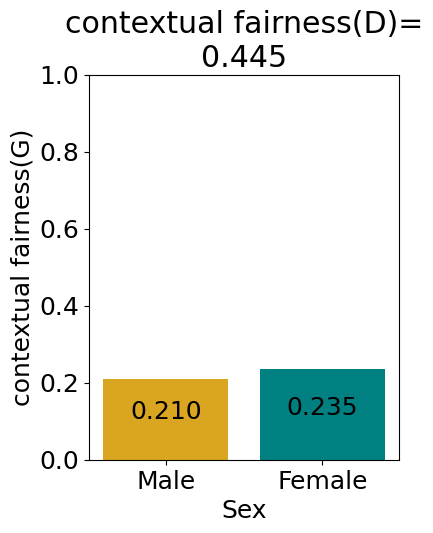

In [61]:
groups = [
    [
        scaled_group_scores.filter(pl.col("SEX") == 1.0).select("total").item(),
        scaled_group_scores.filter(pl.col("SEX") == 2.0).select("total").item(),
    ],
]

group_plot(
    groups,
    xticks=["Male", "Female"],
    xlabel="Sex",
    ylabel="contextual fairness(G)",
    title=f"contextual fairness(D)=\n{total_score:.3f}",
    bar_width=0.8,
    show_difference=False,
    fig_width=4,
    fig_height=5,
)

### Plot distribution of in-group scores

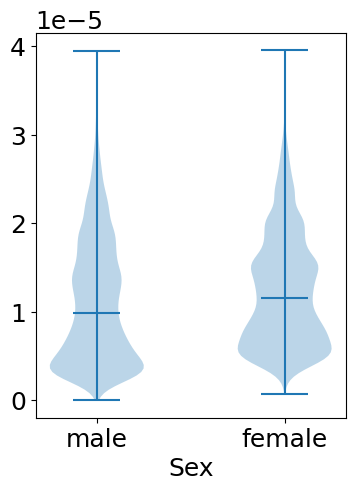

In [43]:
violin_data = [
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 1.0))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 2.0))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
]

fig, ax = plt.subplots(figsize=(4, 5))
ax.violinplot(violin_data, showmeans=False, showmedians=True)
ax.set_xticks(
    [y + 1 for y in range(len(violin_data))],
    labels=["male", "female"],
)
ax.set_xlabel("Sex")
# ax.set_title("Distribution of contextual \nfairness within each group")

plt.show()